In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objects as go

import random
import openpyxl


As mentioned in the 'df_cleaning.ipynb', I will utilize both the filtered dataset and the full dataset for conducting exploratory data analysis (EDA). I will import the filtered cleaned data in the previous section. The full dataset will be cleaned as needed during the analysis. 

In [45]:
full_data = pd.read_pickle('df_accepted.plk')
filtered_data = pd.read_csv('2015_2018_cleaned_dataset.csv')


I create copies of each dataset here to ensure that I do not modify the original data. This allows me to preserve the integrity of the original datasets, which I may need for later reference and comparison.

In [46]:
full_df = full_data.copy()
filtered_df = filtered_data.copy()


In [54]:
# Use the 'pitayasmoothie-dark' style for matplotlib
plt.style.use('Solarize_Light2')


Text(0.5, 1.0, 'Loans issued over the years')

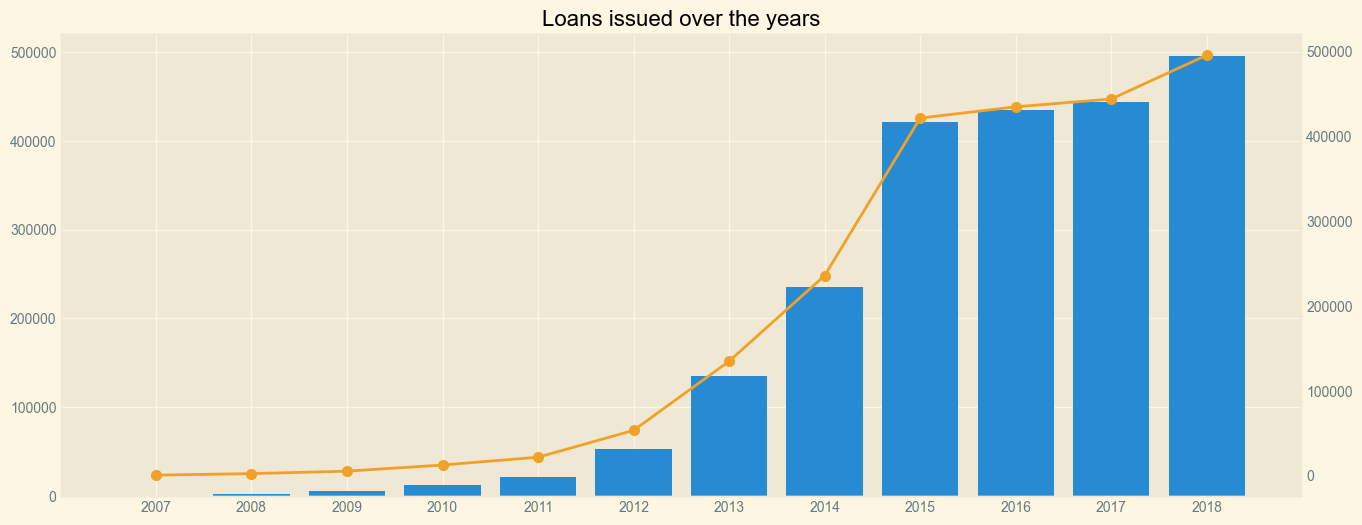

In [56]:
# Create a new column for year extracted from 'issue_d'
full_df['issue_d_y'] = full_df['issue_d'].dt.strftime('%Y')
# Group by year and count occurrences
grouped = full_df['issue_d_y'].value_counts().sort_index().reset_index()
# Plotting
plt.figure(figsize=(16, 6))
# Bar plot
plt.bar(data=grouped, x='issue_d_y', height='count', label='Count')
# Line plot with twinx for overlay
plt.twinx()
plt.plot(
         grouped['issue_d_y'], grouped['count'], color='#f1a226',\
         marker='o', linestyle='-', linewidth=2, markersize=7, label='Count (line)', 
         )
# Labels and titles
plt.grid(False)
plt.xlabel('Year')
plt.ylabel('')
plt.title('Loans issued over the years', fontsize = 16, color = 'black')



In [6]:
grouped = full_df.groupby(['issue_d_y']).size().sort_index().pct_change()
grouped

issue_d_y
2007         NaN
2008    2.968491
2009    1.206853
2010    1.373982
2011    0.732552
2012    1.456931
2013    1.526168
2014    0.747808
2015    0.787110
2016    0.031613
2017    0.021114
2018    0.116469
dtype: float64

Text(0.5, 1.0, 'Annual Growth Rate of Loans Issued from Lending Club')

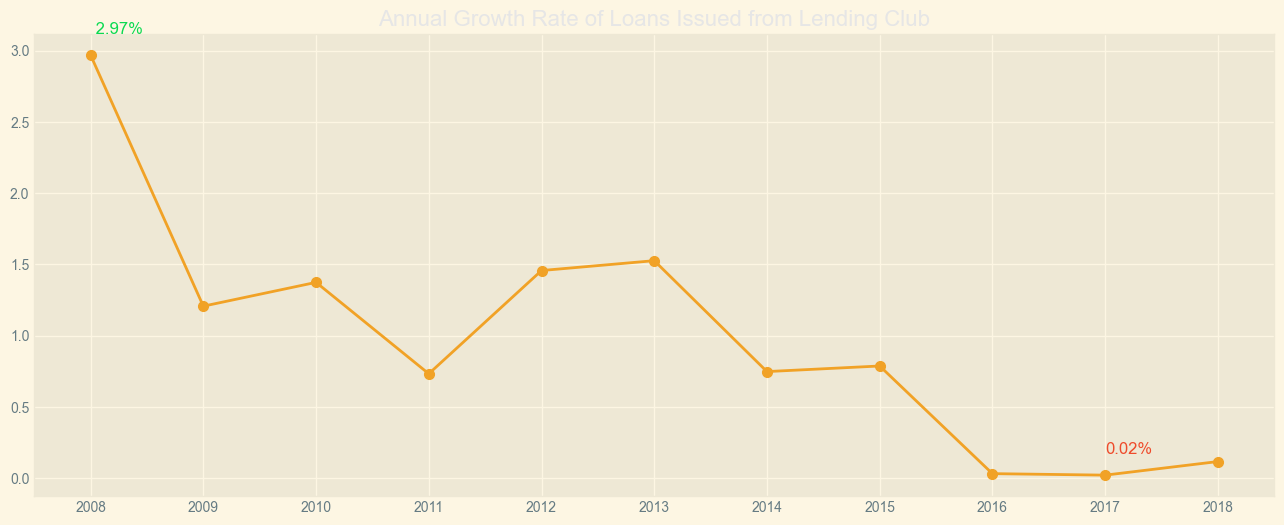

In [57]:
plt.figure(figsize = (16,6))
grouped = full_df.groupby(['issue_d_y']).size().sort_index().pct_change()
plt.plot(
         grouped, color='#f1a226',
         marker='o', linestyle='-', linewidth=2, markersize=7, label='Count (line)'
         )
highest_point = grouped.idxmax()
lowest_point = grouped.idxmin()

highest_value = grouped.max()
lowest_value = grouped.min()

plt.annotate(f'{highest_value: .2f}%',
             xy = (lowest_point, lowest_value + 0.5),
             xytext = (highest_point, highest_value + 0.15),
             fontsize =12,
             color = '#0BDA51'
          )
plt.annotate(f'{lowest_value:.2f}%',
             xy = (lowest_point, lowest_value + 0.15),
             fontsize = 12,
             color = '#EE4B2B'
)

plt.title('Annual Growth Rate of Loans Issued from Lending Club')

It is evident that the growth rate of loans issued by Lending Club has been declining over the years. 


This trend suggests several potential factors at play. Lending Club may have reached a point where the market for its services is saturated, meaning there are fewer new borrowers entering the market. Other peer-to-peer lending platforms or traditional financial institutions might be capturing a larger share of the market, impacting Lending Club's growth. Other factor could be new regulations have been placed to limit the default rate. In addition, Change in borrower behavior is another important factor. Borrowers might be seeking alternative financing options, such as fintech solutions, other lending platforms, or traditional bank. A declining growth rate might affect investor confidence and the valuation of Lending Club. Therefore, the company needs to adapt its business model to mitigate the impact, such as diversifying its product range, exploring new loan products, personalized services, enhancing marketing efforts or optimizing operations. 

In [8]:
issued_by_months = full_df.groupby(['issue_d_y','issue_d']).size().to_frame('Count').reset_index()
idmax = issued_by_months.groupby(['issue_d_y'])['Count'].idxmax()
issued_by_months.loc[idmax]

,issue_d_y,issue_d,Count
6,2007,2007-12-01,172
9,2008,2008-03-01,402
29,2009,2009-11-01,662
42,2010,2010-12-01,1335
54,2011,2011-12-01,2267
65,2012,2012-11-01,6382
78,2013,2013-12-01,15020
88,2014,2014-10-01,38783
100,2015,2015-10-01,48631
105,2016,2016-03-01,61992


In [9]:
# Customize format function
def format_func(num):
  magnitude = 0
  while abs(num) >= 1000:
    magnitude += 1
    num /=1000
  return '%.2f%s' % (num, ['', 'K', 'M'][magnitude])

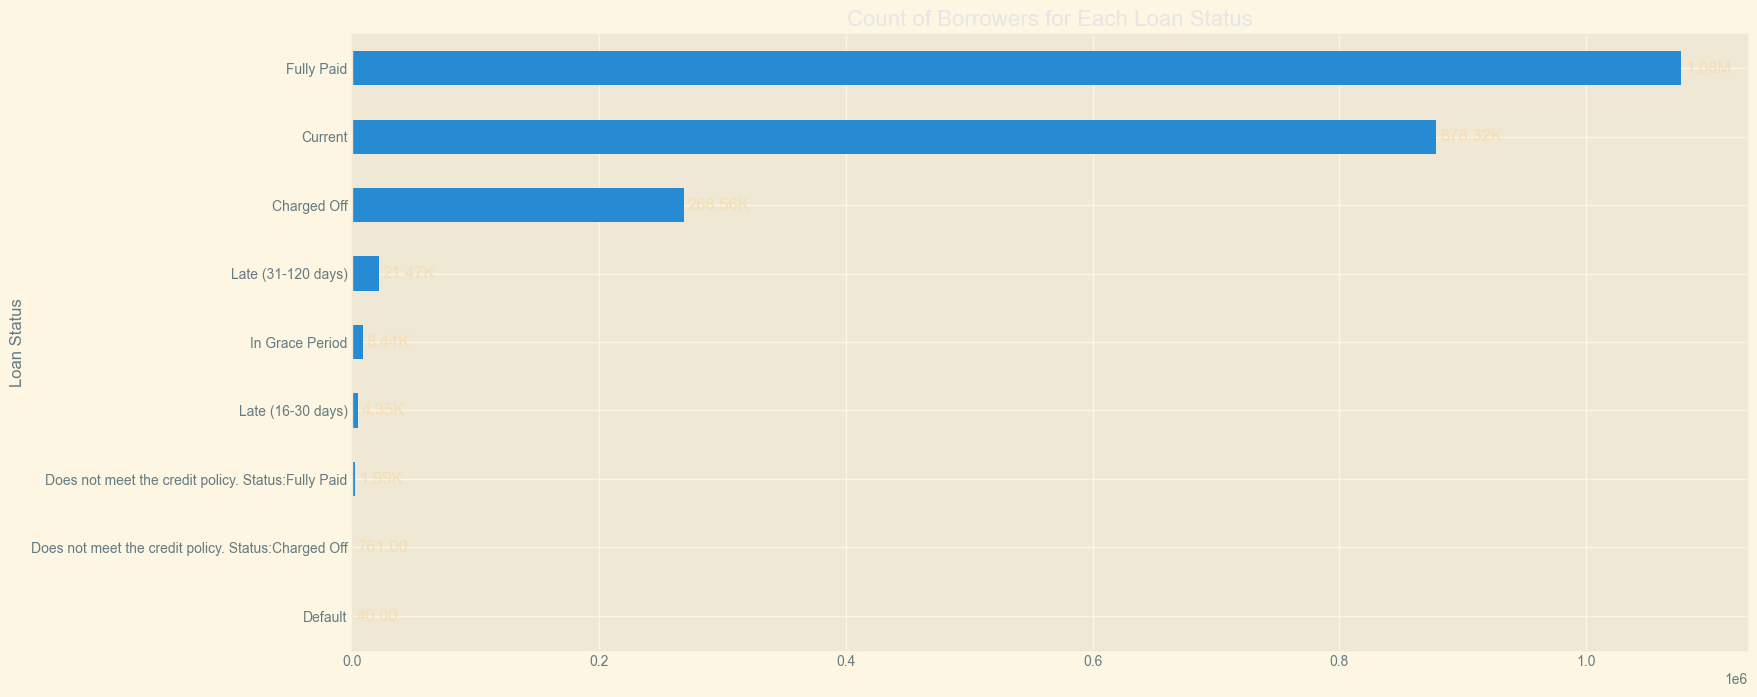

In [58]:
# Count occurrences of each loan status
status_counts = full_df['loan_status'].value_counts().sort_values()

# Plot horizontal bar chart
plt.figure(figsize = (18,8))
ax = status_counts.plot(kind='barh')

# Label the last four bars because their values are too small to be easily visible.
ax.bar_label(ax.containers[0], fmt = format_func, fontsize=12, padding=3, color = '#F5DEB3')


ax.set_xlabel('')
ax.set_ylabel('Loan Status')
ax.set_title('Count of Borrowers for Each Loan Status')
plt.show()


For the purpose of simplying the analysis, I will categorize the loans into two main groups: good loans and bad loans. Good loans will include those that are 'Fully Paid'. Bad loans will encompass statuses such as 'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)','Does not meet the credit policy. Status:Charged Off' and 'Default'. This classification will help in distinguishing between successfully repaid loans and those that encountered repayment issues.

In [11]:
# List of loan statuses considered as bad loans or good loans
bad_loans = ['Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 
             'Does not meet the credit policy. Status:Charged Off', 'Default']
good_loans = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
# Update loan_status column for bad and good loans for both full dataset and filtered dataset
full_df.loc[full_df['loan_status'].isin(bad_loans), 'loan_status'] = 'bad loans'
full_df.loc[full_df['loan_status'].isin(good_loans), 'loan_status'] = 'good loans'

filtered_df.loc[filtered_df['loan_status'].isin(bad_loans), 'loan_status'] = 'bad loans'
filtered_df.loc[filtered_df['loan_status'].isin(good_loans), 'loan_status'] = 'good loans'
#filter only good and bad loans data
full_df = full_df[full_df['loan_status'].isin(['good loans', 'bad loans'])]
filtered_df = filtered_df[filtered_df['loan_status'].isin(['good loans', 'bad loans'])]
full_df.loan_status.unique()

array(['good loans', 'bad loans'], dtype=object)

In [12]:
cm = sns.light_palette('#298c8c', as_cmap=True)
table = full_df['loan_status'].value_counts(normalize = True)*100
table.to_frame().style.background_gradient(cmap = cm)

,proportion
loan_status,
good loans,78.515701
bad loans,21.484299


Out of the total loans from the dataset, 21% are classified as bad loans. For lenders, this high percentage underscores the importance of rigorous risk assessment and the need for effective risk management strategies. 



In [13]:

cm = sns.light_palette('#298c8c', as_cmap=True)
table = filtered_df['loan_status'].value_counts(normalize = True)*100
table.to_frame().style.background_gradient(cmap = cm)



,proportion
loan_status,
good loans,75.262210
bad loans,24.737790


When constructing our model later on, it will be essential to address the challenge posed by the unbalanced dataset. 

In [14]:
import pandas as pd

# Load US state geocode data
geo_code = pd.read_csv('US_GeoCode.csv')

# Group by state and loan status, calculate counts
grouped_state = full_data.groupby(['addr_state']).size().to_frame('Total_loans').reset_index()

# Calculate percentage of bad loans for each state (not include other loan status other than the good and bad loans defined earlier)
grouped_state_status = (full_df.groupby(['addr_state'])['loan_status'].value_counts(normalize = True)*100)\
                                                                                                .round(2).reset_index()
grouped_bad_status = grouped_state_status[grouped_state_status['loan_status'] == 'bad loans'].reset_index(drop = True)
grouped_state['bad_Pct'] = grouped_bad_status['proportion']

# Merge with geocode data based on state
grouped_state = pd.merge(grouped_state, geo_code, left_on='addr_state', right_on='state&teritory', how='inner')


# Filter data for 'bad loans'
data_frame = grouped_state.sort_values(by = 'bad_Pct', ascending = False).reset_index()

# Select top 5 highest and bottom 5 lowest values
top_10_pct = data_frame.nlargest(10, 'bad_Pct')
top_10_total = data_frame.nlargest(10, 'Total_loans')
bottom_10_pct = data_frame.nsmallest(10, 'bad_Pct')
bottom_10_total = data_frame.nsmallest(10, 'Total_loans')

# Highlight top and bottom values
data_frame['Highlight_pct'] = ''
data_frame['Highlight_total'] = ''

data_frame.loc[top_10_pct.index, 'Highlight_pct'] = 'top'
data_frame.loc[top_10_total.index, 'Highlight_total'] = 'top'
data_frame.loc[bottom_10_pct.index, 'Highlight_pct'] = 'bottom'
data_frame.loc[bottom_10_total.index, 'Highlight_total'] = 'bottom'
# Create choropleth map
fig = px.choropleth(
    data_frame=data_frame,
    locationmode="USA-states",
    locations='addr_state',
    color='bad_Pct',
    scope='usa',
    color_continuous_scale='OrRd',
    title='Choropleth Map of Bad Loan Percentages and Bubble Plot of Total Loans Issued',

)
hover_text = [
    f'<b>State:</b> {row["addr_state"]}<br><b>Total Loans:</b> {row["Total_loans"]:,}'
    for index, row in data_frame.iterrows()
]

# Add bubble plot with markers
fig.add_trace(
    go.Scattergeo(
        locationmode='USA-states',
        lon=data_frame['longitude'],
        lat=data_frame['latitude'],
        marker=dict(
            size=data_frame['Total_loans']/500,
            sizemode='area',
            color = '#7393B3'
        ),
        hoverinfo='text',
        text = hover_text

    )
)
# add table
fig.add_trace(
  go.Table(
    header=dict(
        values = ['State', 'Bad_Pct', 'Total'],
        font = dict(size = 10, weight = 'bold')
    ),
    cells=dict(values = [data_frame['addr_state'],
                         data_frame['bad_Pct'].round(2), 
                         data_frame['Total_loans'].map(format_func)],
                         fill=dict(color=[
                         ['white' for i in data_frame['addr_state']],
                         data_frame['Highlight_pct'].map({'top': '#FFA07A', 'bottom': '#FBCEB1', '':'white'}),
                         data_frame['Highlight_total'].map({'top': '#B6D0E2', 'bottom': '#cfd6dc', '': 'white'})
            ])),
    domain=dict(x=[0.85, 0.999], y=[0.01, 0.99]),
    columnwidth=[10, 10,12],
  )
)
#update layout
fig.update_layout(
    geo=dict(
        projection_type='albers usa',
        showland=True,
        landcolor='white',
        subunitwidth=1,
        countrywidth=1
    ),
    plot_bgcolor='#f0f0f0',
    geo_bgcolor='#f0f0f0',
     height=600,
    title_x=0.5
)
fig.show()

From the map, we can observe several key insights regarding the distribution of loans issued by Lending Club across various states. 


- New York, California, Texas and Florida stand out as the states with the largest number of loans issued. This can be attributed to their larger populations and higher economic activity, which likely result in greater demand for personal loans 
- Iowa is the state with the least number of loans issued by Lending Club. This might reflect its smaller population compared to the high-volume states, potentially lower demand for personal loans, or the lesser popularity of the online form of borrowing like Lending Club within the state
- Missisippi emerges as the state with the highest percentage of bad loans. This could be indicative of various socio-economic factors, including lower average income levels, higher unemployment rates, or higher unemployment rates, or other economic challenges that increase the risk of loan defaults
-The high percentage of bad loans in Mississipi highlights the importance of understanding regional economic conditions when assessing credit risk. Lenders might need to implement stricter credit evaluation processes or tailor financial products and services that meet the specific needs of different regions to mitigate the risk of defaults in regions that have high percentage of bad loans such as Mississipi. 

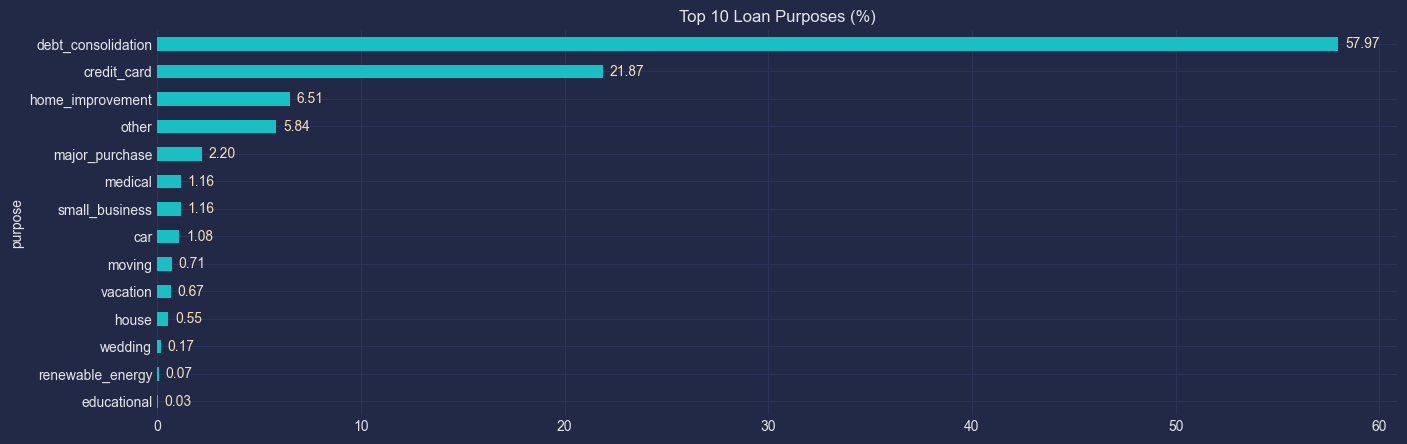

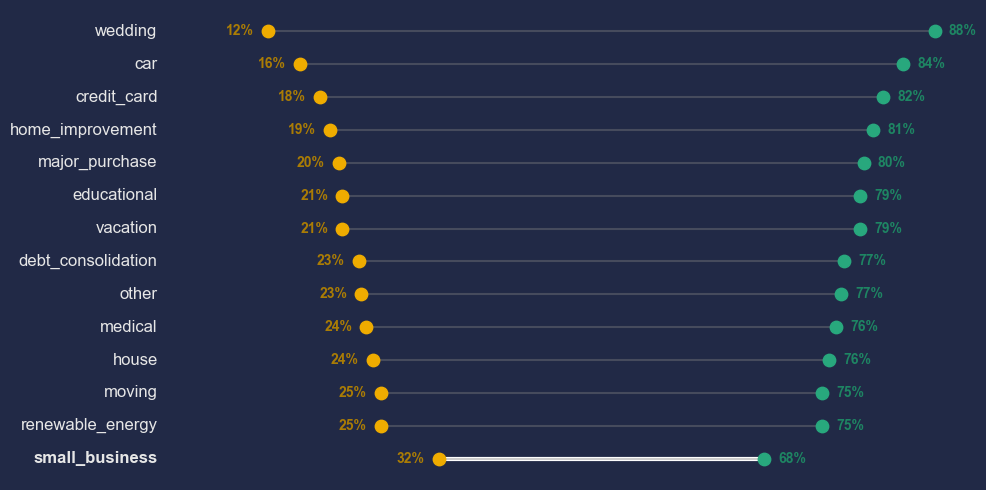

In [15]:
fig, ax = plt.subplots(figsize=(16,5))

grouped_purpose = (full_df['purpose'].value_counts(normalize=True).round(4)*100)
ax = grouped_purpose.sort_values(ascending=True).plot.barh()
for container in ax.containers:
  ax.bar_label(container, fmt = f'%.2f', fontsize=10, padding=5, color = '#F5DEB3')
plt.title('Top 10 Loan Purposes (%)')
plt.show()

loan_status_purpose = full_df.groupby(['purpose'])['loan_status'].value_counts(normalize=True).unstack(level = 1).reset_index().sort_values(by='bad loans', ascending = False).reset_index(drop=True)
good_loans = loan_status_purpose['good loans']
bad_loans = loan_status_purpose['bad loans']

bad_color, good_color = "#EFAC00", "#28A87D",
bad_color_dark, good_color_dark = "#aa7c05", "#1e8563"
fig, ax = plt.subplots(figsize=(10,5))
my_range = range(loan_status_purpose['purpose'].nunique())
ax.hlines(y = my_range, xmin=bad_loans, xmax=good_loans, color ='grey', alpha = 0.4)
ax.scatter(bad_loans, my_range, color = bad_color, zorder = 2, s=80)
ax.scatter(good_loans, my_range, color = good_color, zorder = 2, s=80)
n = len(loan_status_purpose)
for i in range(loan_status_purpose['purpose'].nunique()):
  purpose_name = loan_status_purpose['purpose'][i]
  if purpose_name == 'small_business':
    font='bold'
    purpose_highest_bad = loan_status_purpose[loan_status_purpose['purpose'] == purpose_name]
    ax.hlines(y=i, xmin =  purpose_highest_bad['bad loans'], xmax = purpose_highest_bad['good loans'], linewidth =3, color = 'white', zorder = 1 )
  else:
    font = 'medium'
  ax.text(
        0, i, f'{purpose_name}',
        ha='right', va='center',
        fontsize=12, fontweight=font
    )
  bad = loan_status_purpose['bad loans'][i]
  ax.text(
        bad - 0.016, i,
        f"{bad*100:.0f}%",
        ha='right',
        va='center',
        fontsize=10,
        fontweight='bold',
        color=bad_color_dark
    )
  good = loan_status_purpose['good loans'][i]
  ax.text(
        good + 0.016, i,
        f"{good*100:.0f}%",
        ha='left',
        va='center',
        fontsize=10,
        fontweight='bold',
        color=good_color_dark
    )
ax.set_axis_off()

plt.tight_layout()
plt.show()


Among all loan purposes, debt consolidation has the largest number of loans, followed by credit card and home improvement. Small business loans stand out with the highest proportion of bad loans, while wedding loans have the lowest. 


Given that small business loans have the highest proportion of bad loans, it's crucial to enhance risk assessment and management practices specific to this category. Consider stricter eligibility criteria, more thorough financial scrutiny, and perhaps specialized loan products that cater to small businesses' unique challenges.

In [16]:
# replace home_ownership data entries with 'other' for 'ANY' and 'NONE'
full_df.loc[full_df['home_ownership'].isin(['ANY','NONE']),'home_ownership'] = 'OTHER'


<Figure size 1600x800 with 0 Axes>

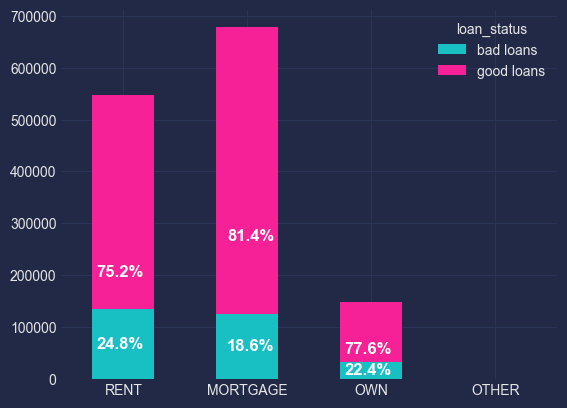

In [17]:
grouped_home_ownership_cnt = full_df.groupby(['home_ownership'])['loan_status'].value_counts().unstack(level=1).sort_values(by ='bad loans', ascending = False)
grouped_home_ownership_pct = full_df.groupby(['home_ownership'])['loan_status'].value_counts(normalize = True).unstack(level=1)

#plot stacked bar showing the count of each loan status in each type of homeownership
plt.figure(figsize=(16,8))
grouped_home_ownership_cnt.plot(kind = 'bar', stacked = True)
#add labels showing proportions of loan status for each type of homeownership
for home_ownership in ['RENT', 'MORTGAGE','OWN']:
    for loan_status in ['bad loans', 'good loans']:
        count = grouped_home_ownership_cnt.loc[home_ownership, loan_status]
        pct = grouped_home_ownership_pct.loc[home_ownership, loan_status]
        if count > 0: 
            plt.text(
                grouped_home_ownership_cnt.index.get_loc(home_ownership) + (0.025 if home_ownership == 'MORTGAGE' else -0.025),
                count - count / 2,

                f'{pct:.1%}',
                ha='center',
                va='center',
                color='white',
                fontsize=12,
                fontweight='bold'
            )

plt.xticks(rotation=0)
plt.xlabel('') 
plt.show()

Although borowers who are currently making payments on a mortgage loan account for the largest number of total loans, those with rental status have the highest proportion of delinquent or defaulted loans (bad loans).

Home ownership status could be a significant factor in predicting loan default risk.


Now, I will perform a permutation test to determine whether there is a significant difference in the proportion of bad loans between the RENT and MORTGAGE homeownership groups. I chose to use a permutation test over other non-parametric tests because it allows for resampling of the data. This method enables me to assess whether the observed difference falls within the range of random chance or represents a true difference in proportions between the two groups, even without having predefined samples. 

In [18]:
grouped_home_ownership_cnt.unstack().to_frame('Count').reset_index()

,loan_status,home_ownership,Count
0,bad loans,RENT,135768
1,bad loans,MORTGAGE,126135
2,bad loans,OWN,33152
3,bad loans,OTHER,121
4,good loans,RENT,411258
5,good loans,MORTGAGE,551956
6,good loans,OWN,115106
7,good loans,OTHER,419


In [19]:
# Reorganize the grouped_home_ownership_cnt table and add the sum along both axes
grouped_home_ownership_cnt = grouped_home_ownership_cnt.unstack().to_frame('Count').reset_index()
grouped_home_ownership_cnt = pd.pivot(grouped_home_ownership_cnt, columns = 'home_ownership', index='loan_status', values = 'Count' )[['MORTGAGE', 'RENT']]

grouped_home_ownership_cnt.loc['sum']  = grouped_home_ownership_cnt.sum(axis = 0)
grouped_home_ownership_cnt['sum'] = grouped_home_ownership_cnt.sum(axis = 1)
grouped_home_ownership_cnt



home_ownership,MORTGAGE,RENT,sum
loan_status,,,
bad loans,126135,135768,261903
good loans,551956,411258,963214
sum,678091,547026,1225117


In [20]:
#permutation test
'''
def perm_fun(x, nA, nB):
  n = nA + nB
  idx_B = set(random.sample(range(n), nB))
  idx_A = set(range(n)) - idx_B
  return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

mort_cnt = grouped_home_ownership_cnt.at['sum','MORTGAGE']
rent_cnt = grouped_home_ownership_cnt.at['sum','RENT']

mort_bad_cnt = grouped_home_ownership_cnt.at['bad loans', 'MORTGAGE']
rent_bad_cnt = grouped_home_ownership_cnt.at['bad loans', 'RENT']

mort_bad_pct = mort_bad_cnt/mort_cnt*100
rent_bad_pct = rent_bad_cnt/rent_cnt*100

obs_pct_dif = rent_bad_pct - mort_bad_pct
print(f'Observed difference: {obs_pct_dif}')

bad_cnt = grouped_home_ownership_cnt.at['bad loans', 'sum']
good_cnt = grouped_home_ownership_cnt.at['good loans', 'sum']

loan_st = [1] * bad_cnt
loan_st.extend([0] * good_cnt)
loan_st = pd.Series(loan_st)
perm_diffs = [100 *  perm_fun(loan_st, mort_cnt, rent_cnt) 
              for _ in range(3000)]
'''



"\ndef perm_fun(x, nA, nB):\n  n = nA + nB\n  idx_B = set(random.sample(range(n), nB))\n  idx_A = set(range(n)) - idx_B\n  return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()\n\nmort_cnt = grouped_home_ownership_cnt.at['sum','MORTGAGE']\nrent_cnt = grouped_home_ownership_cnt.at['sum','RENT']\n\nmort_bad_cnt = grouped_home_ownership_cnt.at['bad loans', 'MORTGAGE']\nrent_bad_cnt = grouped_home_ownership_cnt.at['bad loans', 'RENT']\n\nmort_bad_pct = mort_bad_cnt/mort_cnt*100\nrent_bad_pct = rent_bad_cnt/rent_cnt*100\n\nobs_pct_dif = rent_bad_pct - mort_bad_pct\nprint(f'Observed difference: {obs_pct_dif}')\n\nbad_cnt = grouped_home_ownership_cnt.at['bad loans', 'sum']\ngood_cnt = grouped_home_ownership_cnt.at['good loans', 'sum']\n\nloan_st = [1] * bad_cnt\nloan_st.extend([0] * good_cnt)\nloan_st = pd.Series(loan_st)\nperm_diffs = [100 *  perm_fun(loan_st, mort_cnt, rent_cnt) \n              for _ in range(3000)]\n"

In [21]:
'''fig, ax = plt.subplots(figsize = (18,8))
ax.hist(perm_diffs, bins = 11, rwidth = 0.9)
ax.axvline(x = obs_pct_dif, color = 'yellow', lw = 2)
ax.text(5.9,500, 'observed difference', bbox = {'facecolor':'black'})
ax.set_xlabel('Bad boans (pct)')
ax.set_ylabel('Frequency')'''

"fig, ax = plt.subplots(figsize = (18,8))\nax.hist(perm_diffs, bins = 11, rwidth = 0.9)\nax.axvline(x = obs_pct_dif, color = 'yellow', lw = 2)\nax.text(5.9,500, 'observed difference', bbox = {'facecolor':'black'})\nax.set_xlabel('Bad boans (pct)')\nax.set_ylabel('Frequency')"

As you can see from the graph, the observed difference is well above the range of random chance, which means that the difference in the bad loans proportions between the two groups is significant.

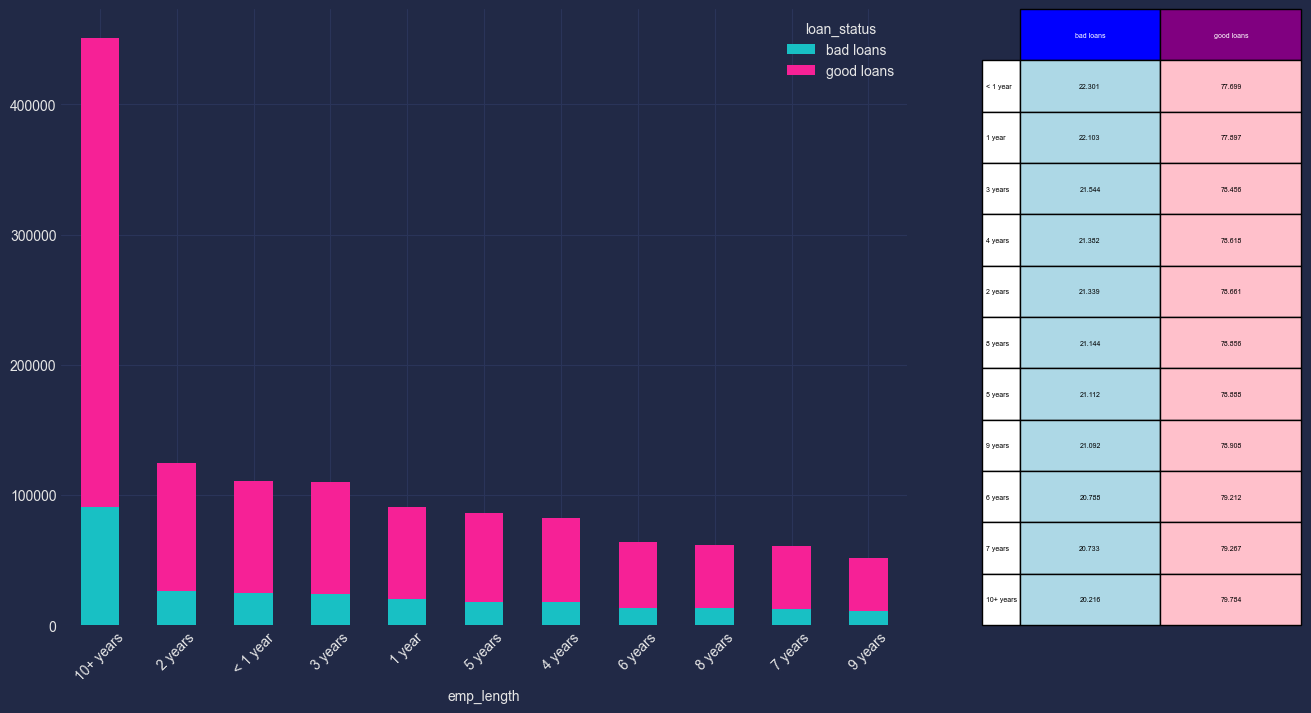

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), width_ratios=(3,1))

# Group by 'emp_length' and get value counts for 'loan_status', then unstack and sort
loan_status_by_length = full_df.groupby(['emp_length'])['loan_status'].value_counts().unstack(level=1).sort_values(by='bad loans', ascending=False)

# Plot the grouped data as a stacked bar chart
loan_status_by_length.plot(kind='bar', stacked=True, ax=ax1)

# Group by 'emp_length' and get normalized value counts for 'loan_status', then unstack and sort
loan_status_by_length_pct = (full_df.groupby(['emp_length'])['loan_status'].value_counts(normalize=True)*100).unstack(level=1).sort_values(by='bad loans', ascending=False)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
# Display the grouped data as a table in the second subplot
ax2.axis('off')  # Turn off the axis
table = ax2.table(cellText=loan_status_by_length_pct.values.round(3),
                  colLabels=loan_status_by_length_pct.columns,
                  rowLabels=loan_status_by_length_pct.index,
                  cellLoc='center',
                  loc='center',
                  colColours=['blue', 'purple'],  # Background color for column headers
                  cellColours=[['lightblue', 'pink']]*len(loan_status_by_length_pct.index),  # Alternate row colors
                  colWidths=[0.15, 0.15],
                  fontsize = 14,
                  bbox=[0, 0, 1, 1])  
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(fontsize=14, color='white')  # Adjust header font size and color
    else:  # Data rows
        cell.set_text_props(fontsize=14, color='black')  # Adjust data font size and color
plt.show()


As depicted, borrowers with 10 years of experience accounted for the highest number of loans issued, and they also exhibited the lowest incidence of defaults. Conversely, individuals with only 1 year of work experience had the highest proportion of bad loans


<Axes: ylabel='emp_title'>

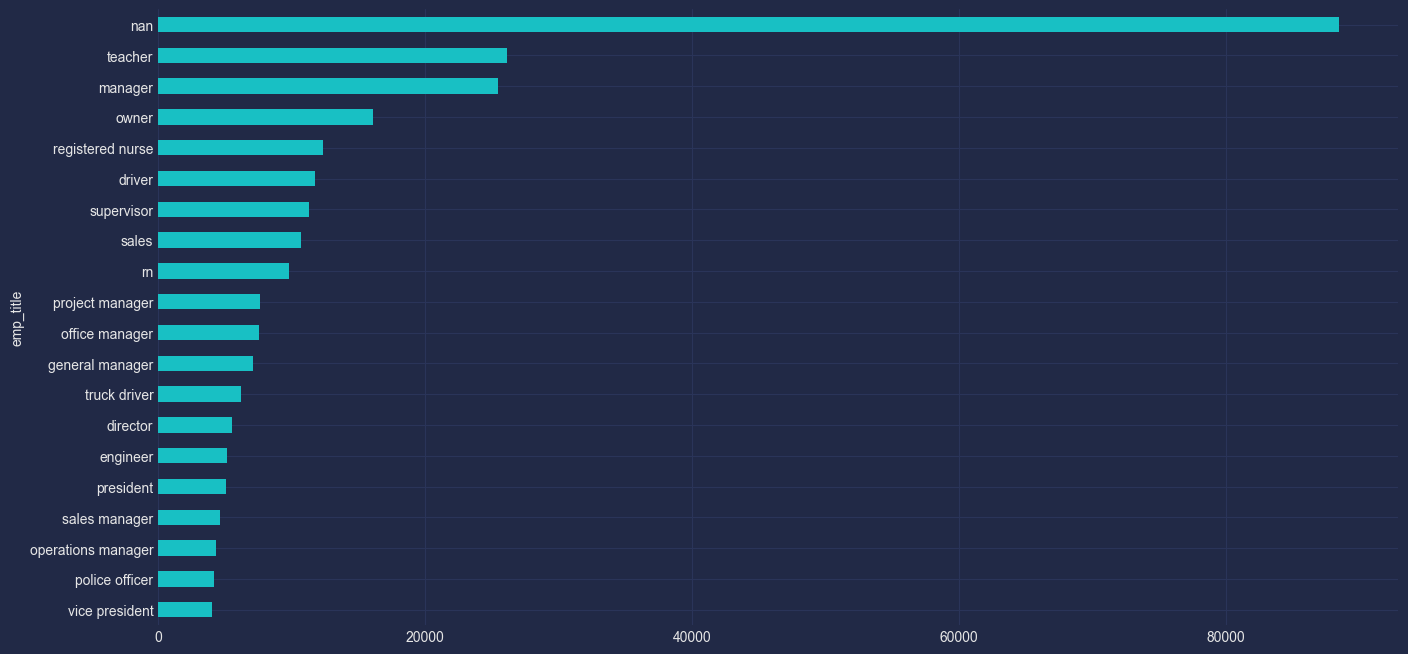

In [23]:
plt.figure(figsize=(16,8))
full_df['emp_title'] = full_df['emp_title'].apply(lambda x: str(x).lower() if not None else x)

top_20_emp_title = full_df['emp_title'].value_counts().nlargest(20).sort_values()
top_20_emp_title.plot(kind='barh')


Text(0, 0.5, 'Group')

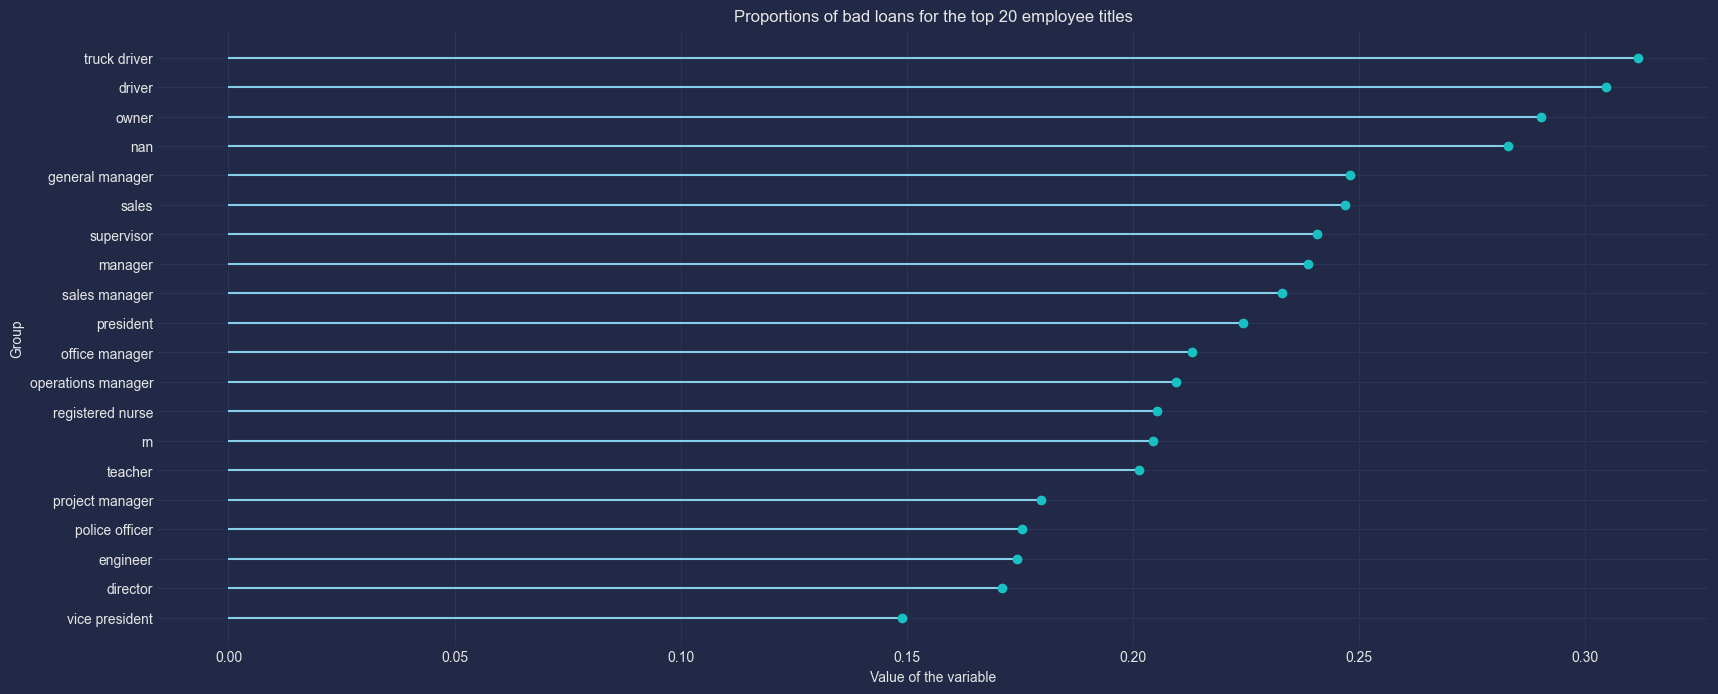

In [24]:
top_20_emp_title_list = [title.lower() for title in list(top_20_emp_title.index)]
full_df['emp_title'] = full_df['emp_title'].apply(lambda x: str(x).lower() if not None else x)
loan_status_by_top_title = (
      full_df.loc[full_df['emp_title'].isin(top_20_emp_title_list)]
      .groupby(['emp_title'])['loan_status']
      .value_counts(normalize = True)
      .unstack()
      .fillna(0)
      )
loan_status_by_top_title['total'] =  (
      full_df.loc[full_df['emp_title'].isin(top_20_emp_title_list)]['emp_title']
      .value_counts()
      )

plt.figure(figsize = (20, 8))
my_range = range(1, len(loan_status_by_top_title)+1)
loan_status_by_top_title = loan_status_by_top_title.sort_values(by='bad loans', ascending=True)['bad loans']
plt.hlines(y=my_range, xmin=0, xmax =loan_status_by_top_title, color = 'skyblue')
plt.plot(loan_status_by_top_title, my_range, 'o')
plt.yticks(my_range, loan_status_by_top_title.index)
plt.title('Proportions of bad loans for the top 20 employee titles')
plt.xlabel('Value of the variable')
plt.ylabel('Group')

In [25]:
full_df['term'] = full_df['term'].apply(lambda x: x.strip() if not None else x )
loan_status_by_term = full_df.groupby('term')['loan_status'].value_counts().unstack(level='loan_status')
loan_status_by_term_pct = full_df.groupby('term')['loan_status'].value_counts(normalize=True).unstack(level='loan_status')
loan_status_by_term_pct

loan_status,bad loans,good loans
term,,
36 months,0.172357,0.827643
60 months,0.346245,0.653755


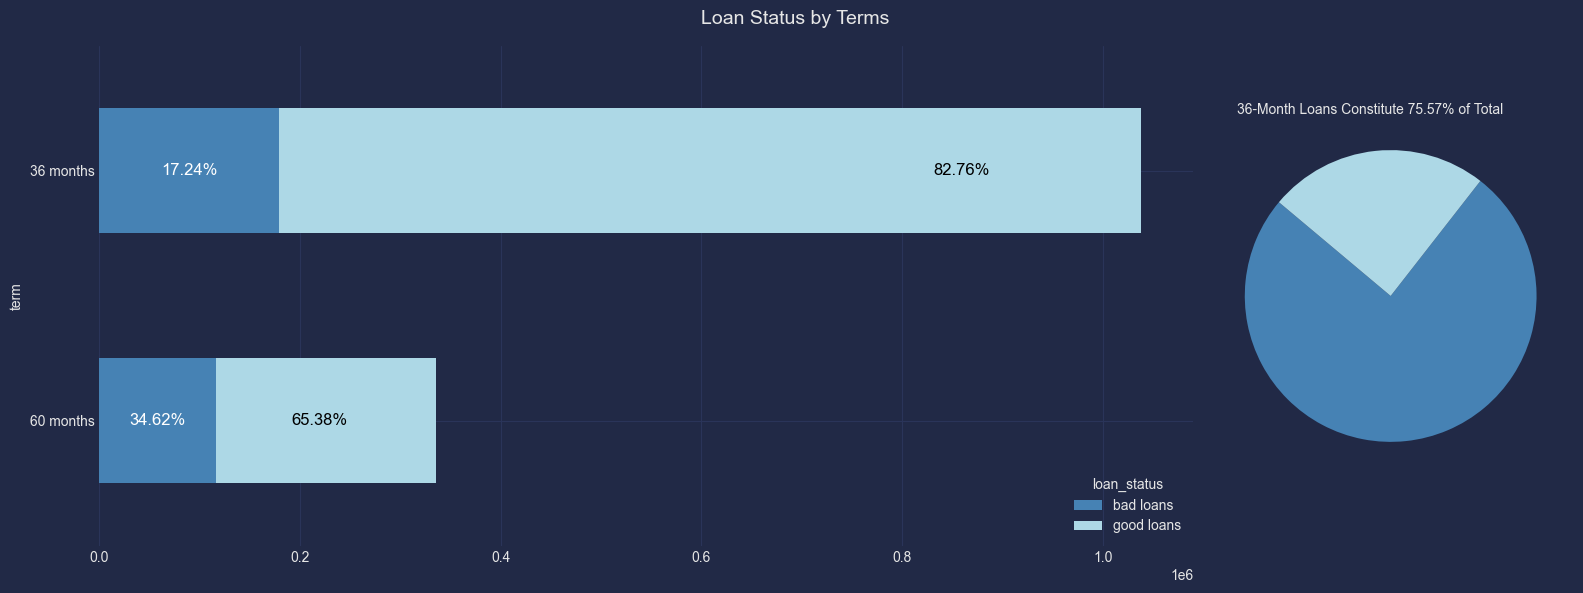

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (16,6), gridspec_kw={'width_ratios': [3, 1]})
loan_status_by_term.sort_values(by = 'bad loans').plot(kind= 'barh', stacked = True, color = ['#4682B4','lightblue'], ax= ax1)
for spine in ax1.spines.values():
    spine.set_visible(False)
ax2.pie(full_df['term'].value_counts(), startangle=140, colors=['#4682B4', 'lightblue'])
term_pct = round(len(full_df[full_df['term']=='36 months'])/len(full_df) * 100,2)
ax2.text(x = -1.05, y=1.25, s=f'36-Month Loans Constitute {term_pct}% of Total')
fig.suptitle('Loan Status by Terms', fontsize = 14, font = 'Arial')

for i,term in enumerate(['60 months', '36 months']):
    for loan_status in ['bad loans', 'good loans']:
        pct = loan_status_by_term_pct.loc[term, loan_status]
        count = loan_status_by_term.loc[term, loan_status]
        if loan_status == 'bad loans':
          ax1.annotate(f'{round(pct*100,2)}%', (count/2,i), ha='center', va='center', color='white', fontsize=12)
        else:
          ax1.annotate(f'{round(pct*100,2)}%', (count,i), ha='center', va='center', color='black', fontsize=12)
plt.tight_layout()


In [27]:
loan_status_by_grade = full_df.groupby('grade')['loan_status'].value_counts().unstack(level=1)
loan_status_by_grade_pct = full_df.groupby('grade')['loan_status'].value_counts(normalize=True).unstack(level=1)
loan_status_by_grade['sum'] = loan_status_by_grade.sum(axis=1)
loan_status_by_grade= loan_status_by_grade.sort_values(by='sum')

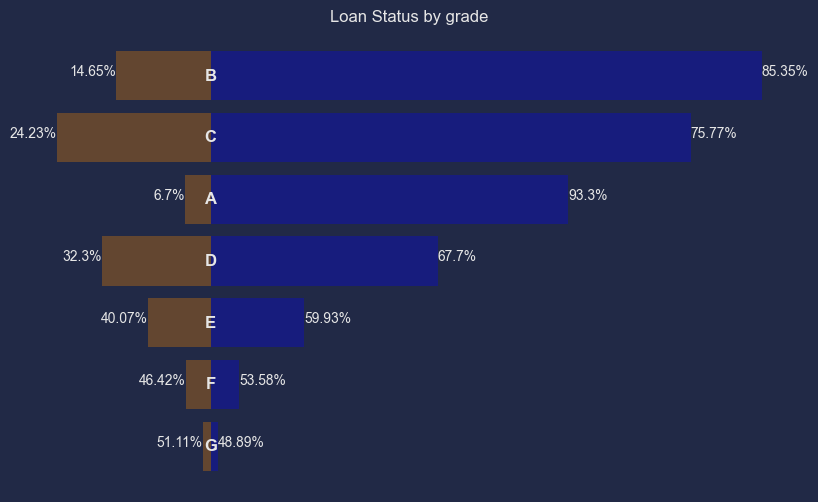

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(loan_status_by_grade.index, loan_status_by_grade['good loans'],
        color = 'blue', alpha = 0.3)
ax.barh(loan_status_by_grade.index, -loan_status_by_grade['bad loans'],
        color = 'darkorange', alpha = 0.3)
ax.set_title('Loan Status by grade')
ax.set_xticks([])
ax.set_yticks([])
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
for i, grade in enumerate(loan_status_by_grade.index):
    ax.text(0, i, grade, ha='center', va='center', fontsize=12, fontweight = 'bold')
    ax.text(-loan_status_by_grade.at[grade,'bad loans'], i, f"{round(loan_status_by_grade_pct.at[grade, 'bad loans']*100,2)}%", ha='right')
    ax.text(loan_status_by_grade.at[grade,'good loans'], i, f"{round(loan_status_by_grade_pct.at[grade, 'good loans']*100,2)}%", ha='left')



Text(0, 0.5, 'We will investigate further the data that has value A in grade feature,\n which accounts for 6.7% of the total of bad loans,\nin another section of this project')

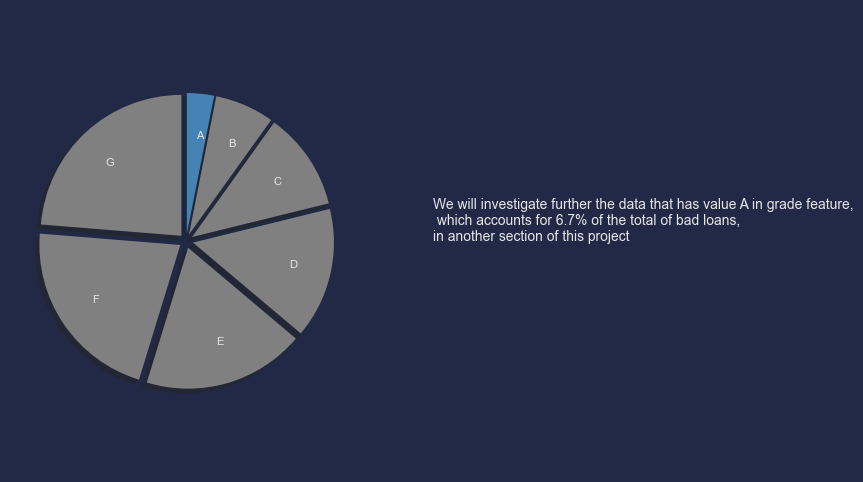

In [29]:
fig, (ax1, ax1_)= plt.subplots(1,2, figsize = (10,6))
explode = [0.05]*7
ax1.pie(loan_status_by_grade_pct['bad loans'], labeldistance=.7, labels = loan_status_by_grade_pct.index,  textprops = {'fontsize':8},
        colors = ['#4682B4'] + ['grey']*6,startangle=90, counterclock=False, shadow = True, explode = explode)
ax1_.axis('off')
for spine in ax1_.spines.values():
    spine.set_visible(False)
pct_A = round(loan_status_by_grade_pct.loc['A','bad loans']*100,2)
ax1_.text(x = 0, y=0.5, s=f'We will investigate further the data that has value A in grade feature,\n which accounts for {pct_A}% of the total of bad loans,\nin another section of this project')


In [30]:
cat_columns = full_df.select_dtypes(include = 'object').columns.drop(
      ['id','url', 'desc','hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_loan_status', 'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date','settlement_date','last_pymnt_d', 'next_pymnt_d',
       'issue_d_y'])
cat_columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan',
       'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line',
       'initial_list_status', 'last_credit_pull_d', 'application_type',
       'verification_status_joint', 'sec_app_earliest_cr_line',
       'hardship_flag', 'hardship_type', 'hardship_reason', 'hardship_status',
       'settlement_status'],
      dtype='object')

In [31]:
'''n_subplots = len(cat_columns)
cols = 3
rows = (n_subplots + cols - 1) // cols
fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axs = axs.flatten()  # Flatten the 2D array of axes into 1D

for i, ax in enumerate(axs):
    if i < n_subplots:
        sns.histplot(data = grade_A,x=grade_A[cat_columns[i]], hue='loan_status', ax=ax)
        ax.set_title(f'{cat_columns[i]}')
    else:
        fig.delaxes(ax)  # Remove extra subplots

plt.tight_layout()
plt.show()'''

"n_subplots = len(cat_columns)\ncols = 3\nrows = (n_subplots + cols - 1) // cols\nfig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))\naxs = axs.flatten()  # Flatten the 2D array of axes into 1D\n\nfor i, ax in enumerate(axs):\n    if i < n_subplots:\n        sns.histplot(data = grade_A,x=grade_A[cat_columns[i]], hue='loan_status', ax=ax)\n        ax.set_title(f'{cat_columns[i]}')\n    else:\n        fig.delaxes(ax)  # Remove extra subplots\n\nplt.tight_layout()\nplt.show()"

In [32]:
filtered_df['emp_title'] = filtered_df['emp_title'].apply(lambda x: str(x).lower())
top_titles_bad_A = filtered_df[filtered_df['grade']=='A']['emp_title'].value_counts().head(30).index

In [34]:

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from kmodes.kmodes import KModes 

def label_encoding(cat_cols, target_col, df,label_mappings):
  label_encoder = LabelEncoder()

  for col in cat_cols:    
    df[col] = label_encoder.fit_transform(df[col])
    label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_),label_encoder.classes_))
    label_mappings[col]=label_mapping

  y_train = label_encoder.fit_transform(df[target_col])
  label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_),label_encoder.classes_))
  label_mappings[target_col]=label_mapping
  return label_mappings, y_train

def target_balancing(X_train, y_train):

  over = SMOTE(sampling_strategy= 0.2)
  under = RandomUnderSampler(sampling_strategy=0.5)

  steps = [('o',over),
           ('u', under)]
  
  pipeline = Pipeline(steps = steps)
  X_train_sm, y_train_sm = pipeline.fit_resample(X_train, y_train)
  return X_train_sm, y_train_sm

def map_vals(cat_cols, label_mappings, df):
  for col in cat_cols:
    df[col] = df[col].map(label_mappings[col])
  return df

 

grade_A= filtered_df[filtered_df['grade']=='A']
pur_homeown_cols = ['home_ownership','purpose']

target_col = 'loan_status'

label_mappings = {}
label_mappings, y_train = label_encoding(pur_homeown_cols, target_col, grade_A, label_mappings)

X_train = grade_A[pur_homeown_cols]

X_train_sm, y_train_sm =target_balancing(X_train, y_train)

A_sm = pd.concat([X_train_sm, pd.Series(y_train_sm).to_frame(target_col)],axis=1)
A_sm_cp = A_sm.copy()







C:\Users\songt\AppData\Local\Temp\ipykernel_13972\1433808574.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\songt\AppData\Local\Temp\ipykernel_13972\1433808574.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
A_sm_cp.dropna(inplace=True)

In [36]:
from plottable import ColumnDefinition, Table
def custom_table(styler):
  styler.background_gradient(cmap = 'Reds',axis=None)
  styler.map(lambda x: 'text-align: center; font-size: 14px')
  return styler
A_sm_cp = map_vals(pur_homeown_cols+[target_col], label_mappings, A_sm_cp)
other_idx = A_sm_cp.loc[A_sm_cp['home_ownership']=='OTHER'].index

pur_homeown_A_df = (
            A_sm_cp.drop(other_idx)
            .groupby(['purpose','home_ownership'])['loan_status']
            .value_counts(normalize=True)
            .unstack(level=2)
            .fillna(0)
)
pur_homeown_A_df.style.pipe(custom_table)


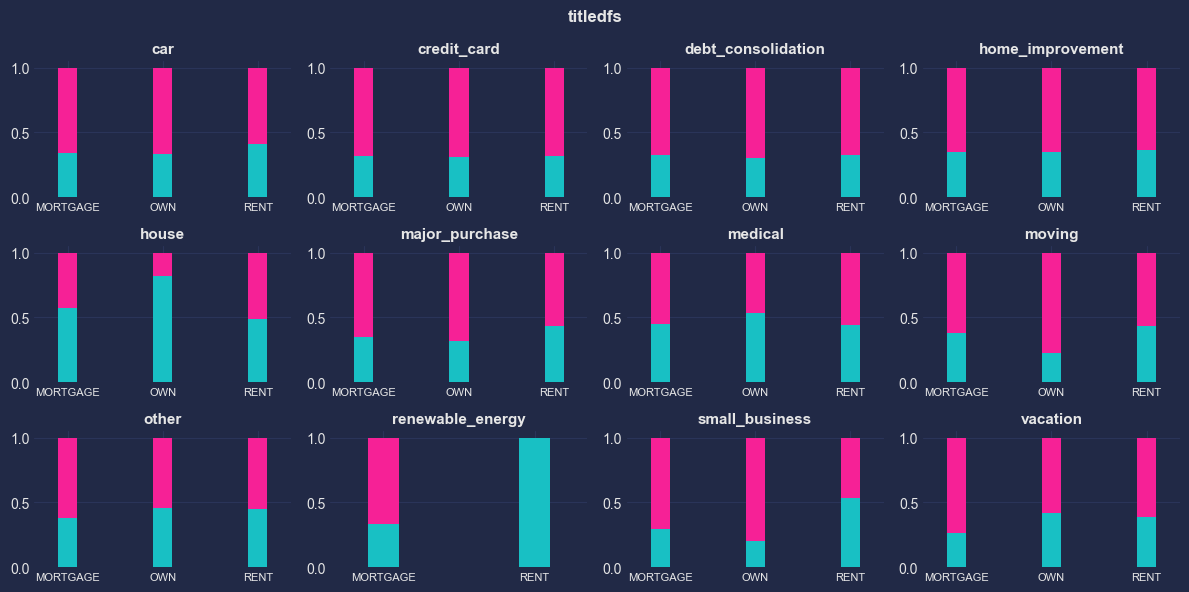

In [37]:

bad_color, good_color = "#EFAC00", "#28A87D",
bad_color_dark, good_color_dark = "#aa7c05", "#1e8563"
fig, axes = plt.subplots(3,4,figsize=(12,6))
axes=axes.flatten()
purposes = pur_homeown_A_df.index.get_level_values('purpose').unique()
for i,ax in enumerate(axes):
    pur_homeown_A = pur_homeown_A_df.loc[purposes[i]]
    bad_loans = pur_homeown_A['bad loans']
    good_loans = pur_homeown_A['good loans']
    pur_homeown_A.plot(ax=ax, kind='bar', stacked=True, width=0.2)

    ax.set_title(f'{purposes[i]}', fontsize = 11, fontweight='bold')
    ax.legend([])
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=8, rotation = 0)
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    ax.set_xlabel(None)

fig.suptitle('titledfs', fontweight='bold')
plt.tight_layout()

plt.show()

In [38]:

grouped=round(A_sm_cp.drop(other_idx).groupby('purpose')['loan_status'].value_counts(normalize=True)*100,2).to_frame().unstack(level=1)
grouped.style.pipe(custom_table)


In [39]:
bins = [0,10000,20000,40000,70000,100000,150000,200000,1000000, 10000000]
labels = ['<10k','10k-20k', '20k-40k', '40k-70k','70k-100k', '100k-150k', '150k-200k','200k-1M', '>1M']
grade_A['annual_inc_binned'] = pd.cut(grade_A['annual_inc'], bins = bins, labels = labels, include_lowest= True)


C:\Users\songt\AppData\Local\Temp\ipykernel_13972\1732106294.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [40]:
emp_tit_len_inc_pur_cols = ['emp_length','emp_title','purpose','annual_inc_binned']
label_mappings = {}
label_mappings, y_train = label_encoding(emp_tit_len_inc_pur_cols, target_col, grade_A, label_mappings)
X_train = grade_A[emp_tit_len_inc_pur_cols]
X_train_sm, y_train_sm = target_balancing(X_train, y_train)
A_sm = pd.concat([X_train_sm, pd.Series(y_train_sm).to_frame('loan_status')], axis=1)
A_sm_cp = A_sm.copy()


C:\Users\songt\AppData\Local\Temp\ipykernel_13972\1433808574.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\songt\AppData\Local\Temp\ipykernel_13972\1433808574.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\songt\AppData\Local\Temp\ipykernel_13972\1433808574.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [41]:
A_sm_cp = map_vals(emp_tit_len_inc_pur_cols+[target_col], label_mappings, A_sm_cp)
A_sm_cp

,emp_length,emp_title,purpose,annual_inc_binned,loan_status
20,2 years,medical coder/biller,2.0,20k-40k,bad loans
22,10+ years,mechanic,2.0,70k-100k,bad loans
34,5 years,human resources,2.0,70k-100k,bad loans
88,1 year,sales,1.0,40k-70k,bad loans
178,10+ years,social worker,2.0,70k-100k,bad loans
...,...,...,...,...,...
48379,NaN,NaN,NaN,NaN,good loans
48380,NaN,NaN,NaN,NaN,good loans
48383,NaN,NaN,NaN,NaN,good loans
48384,NaN,NaN,NaN,NaN,good loans


In [42]:
grouped = A_sm_cp.loc[A_sm_cp['emp_title'].isin(top_titles_bad_A)].groupby(['emp_length','annual_inc_binned'])['loan_status'].value_counts(normalize=True).to_frame().unstack(level = [1]).fillna(0)
grouped.style.pipe(custom_table)


In [43]:
A_sm_cp

,emp_length,emp_title,purpose,annual_inc_binned,loan_status
20,2 years,medical coder/biller,2.0,20k-40k,bad loans
22,10+ years,mechanic,2.0,70k-100k,bad loans
34,5 years,human resources,2.0,70k-100k,bad loans
88,1 year,sales,1.0,40k-70k,bad loans
178,10+ years,social worker,2.0,70k-100k,bad loans
...,...,...,...,...,...
48379,NaN,NaN,NaN,NaN,good loans
48380,NaN,NaN,NaN,NaN,good loans
48383,NaN,NaN,NaN,NaN,good loans
48384,NaN,NaN,NaN,NaN,good loans


<Axes: xlabel='annual_inc_binned'>

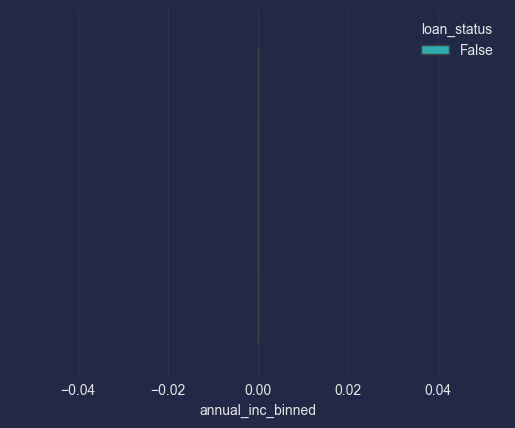

In [44]:
sns.boxplot(A_sm_cp.isin(top_titles_bad_A), x='annual_inc_binned', hue='loan_status')

In [ ]:
grade_A.groupby('emp_length')['loan_status'].value_counts(normalize=True)

emp_length  loan_status
1 year      good loans     0.921394
            bad loans      0.078606
10+ years   good loans     0.922409
            bad loans      0.077591
2 years     good loans     0.918305
            bad loans      0.081695
3 years     good loans     0.924567
            bad loans      0.075433
4 years     good loans     0.919898
            bad loans      0.080102
5 years     good loans     0.924026
            bad loans      0.075974
6 years     good loans     0.933862
            bad loans      0.066138
7 years     good loans     0.917129
            bad loans      0.082871
8 years     good loans     0.929965
            bad loans      0.070035
9 years     good loans     0.929724
            bad loans      0.070276
< 1 year    good loans     0.914719
            bad loans      0.085281
Name: proportion, dtype: float64

In [ ]:
grade_A[grade_A['emp_title'].isin(top_titles_bad_A)].groupby('emp_title')['loan_status'].value_counts(normalize=True).sort_index(level='loan_status')

emp_title           loan_status
account manager     bad loans      0.073930
accountant          bad loans      0.054487
analyst             bad loans      0.052000
attorney            bad loans      0.060606
ceo                 bad loans      0.141079
consultant          bad loans      0.077922
director            bad loans      0.057047
driver              bad loans      0.105915
engineer            bad loans      0.073123
general manager     bad loans      0.088757
manager             bad loans      0.102008
mechanic            bad loans      0.085470
nurse               bad loans      0.092150
office manager      bad loans      0.060000
operations manager  bad loans      0.095541
owner               bad loans      0.138070
police officer      bad loans      0.042493
president           bad loans      0.102837
project manager     bad loans      0.052851
registered nurse    bad loans      0.097980
rn                  bad loans      0.101874
sales               bad loans      0.098540
